<a name="top">&nbsp;</a>
<h1>A Comprehensive Guide to the Total Order Sort With Hadoop Streaming</h1>
<hr>

__by Kyle Hamilton__   
Reservoir sampling implemenation by __Rowan Cassius__ - w261 Summer 2020   
University of California, Berkeley

Modified from the original by Kyle Hamilton, James G. Shanahan, Yiran Sheng     
__Email__: kylehamilton@ischool.berkeley.edu, jimi@ischool.berkeley.edu, yiran@ischool.berkeley.edu




In [168]:
from IPython.display import Image, HTML

In [169]:
with open("code-tab.css",'r') as style:
    code_tab_style = "<style>{}</style>".format(style.read())

HTML(code_tab_style)

<h1>Table of Contents</h1>
 <ul class="toc-item">
    <li><strong class="toc-heading"><a href="#Abstract">Abstract</a></strong></li>
    <li><strong class="toc-heading"><a href="#introduction">Introduction</a></strong></li>
    <li><strong class="toc-heading"><a href="#Terminology">Terminology</a></strong>
       <ul>
          <li><a href="#Hadoop">Hadoop</a></li>
          <li><a href="#Hadoop-Streaming">Hadoop Streaming</a></li>
          <li><a href="#Partial-Sort">Partial Sort</a></li>
          <li><a href="#Total-Sort-(Unorderd-Partitions)">Total Sort (Unorderd Partitions)</a></li>
          <li><a href="#Total-Sort-(Ordered-Partitions)">Total Sort (Ordered Partitions)</a></li>
          <li><a href="#Secondary-Sorting">Secondary Sorting</a></li>
       </ul>
    </li>
    <li><strong class="toc-heading"><a href="#Examples-of-Different-Sort-Types-(in-context-of-Hadoop-and-HDFS)">Examples of Different Sort Types</a></strong></li>
    <li><strong class="toc-heading"><a href="#Anatomy-of-a-MapReduce-Job">Anatomy of a MapReduce Job</a></strong>   
    <li><strong class="toc-heading"><a href="#Prepare-Dataset">Prepare Dataset</a></strong>
    <li><strong class="toc-heading"><a href="#Section1">Section 1 - Understanding Linux Sort</a></strong>
        <ul>
            <li><a href="#importance-of-unix-sort">Importance of Unix Sort</a></li>
            <li><a href="#unix-sort-overview">Unix Sort Overview</a></li>
            <li><a href="#--sort-examples-">Sort Examples</a></li>
        </ul>
    </li>        
    <li><strong class="toc-heading"><a href="#Section2">Section 2 - Hadoop Streaming</a></strong>
        <ul>
            <li><a href="#II.A.-Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></li>
            <li><a href="#Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></li>
            <ol>
              <li><a href="#Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></li>
              <li><a href="#Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></li>
              <li><a href="#Configure-Hadoop-Streaming-2"> Configure Hadoop Streaming: Step 2</a></li>
              <li><a href="#Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></li>
              <li><a href="#Summary-of-Common-Practices">Summary of Common Practices of Sorting Related Configuration</a></li>
              <li><a href="#Side-by-side-Examples">Side-by-side Examples: unix sort vs. hadoop streaming</a></li>
            </ol>
            <li>
              <a href="#Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a>
              <ol>
                <li><a href="#single-reducer-hadoop-streaming">II.C.1. Single reducer</a></li>
                <li><a href="#multiple-reducer-hadoop-streaming">II.C.2. Multiple reducers</a></li>
                <li><a href="#Partitioning-in-Hadoop-streaming">II.C.3. Multiple reducers with ordered partitions</a>
              </ol>
            </li>
        </ul>
   </li>
   <li><strong class="toc-heading"><a href="#Section4">Section 3 - Sampling</a></strong>
        <ul>
            <li><a href="#randomsampling">Random Sampling</a></li>
            <li><a href="#reservoirsampling">Reservoir Sampling</a></li>
        </ul>
    </li>
    <li><strong class="toc-heading"><a href="#Final-Remarks">Final Remarks</a></strong></li>
    <li><strong class="toc-heading"><a href="#Reference">Reference</a></strong></li>
 </ul>


<h2><a name="Abstract">Abstract</a></h2>
<a href="#top">Back to top</a>

Sorting refers to arranging data in a particular format. A sorting algorithm specifies the way to arrange data in a particular order. Most common orders are numerical or lexicographical order. One important application of sorting lies in the fact that information search can be optimized to a very high level if data is stored in a sorted manner. Sorting is also used to represent data in more readable formats. Some of the examples of sorting in real life scenarios are the following.
* Telephone Directory – A telephone directory keeps telephone numbers of people sorted on their names so that names can be searched.
* Dictionary – A dictionary keeps words in alphabetical order so that searching of any word becomes easy.   

Sorting at scale can be accomplished via MapReduce frameworks such as Hadoop Streaming which operates on data records consisting of key-value pairs. This framework, when run in default mode (by specifying either a mapper, a reducer, or both depending on what needs to be accomplished), will generate a partial order sort, whereby the reducer output will be a lot of (partition) files each of which contains key-value records that are sorted within each partition file based on the key. But there is no sort order between records in different partition files (see Figure 3). This is the default behavior for MapReduce frameworks. Sometimes it is desirable to have all data records sorted by a specified key (i.e., different to a partial order sort), across partition boundaries (see Figure 2). This can be accomplished relatively easily using Hadoop Streaming. But to do so one needs to be familiar with some core concepts and design patterns. This paper introduces the building blocks for total sorting in Hadoop Streaming. Numerous complete working examples are also provided to demonstrate the key design patterns in total order sorts. Python is used as the language for driving all three MapReduce frameworks.   

<em>Keywords: total order sort at scale, sorting in Hadoop Streaming, MapReduce</em>


<h2><a name="introduction">INTRODUCTION</a></h2>
<a href="#top">Back to top</a>

In this notebook we are going to demonstrate how to achieve Total Order Sort in Hadoop Streaming. Hadoop Streaming borrows heavily in terms of syntax and semantics from the Unix sort and cut commands, whereby they treat the output of the mapper as series of records, where each record can be interpreted as a collection of fields/tokens that are tab delimited by default. In this way, fields can be specified for the purposes of partitioning (routing), sometimes referred to as the primary key. The primary key is used for partitioning, and the combination of the primary and secondary keys (also specified by the programmer) is used for sorting.   

We'll start by describing the Linux/Unix sort command (syntax and semantics) and build on that understanding to explain Total Order Sort in Hadoop Streaming. Partitioning is not just matter of specifying the fields to be used for routing the records to the reducers. We also need to consider how best to partition the data that has skewed distributions. To that end, we'll demonstrate how to partition the data via sampling and assigning custom keys.   

At each step we are going to build on the previous steps, so it's important to view this notebook in order. For example, we'll cover key points for sorting with a single reducer in the Hadoop Streaming implementation, and these concepts will apply to the subsequent sections.


<h1><a name="asdf">Anatomy of a MapReduce Job</a></h1>
<a href="#top">Back to top</a>

When tackling large scale data problems with modern computing frameworks such as MapReduce (Hadoop), one generally uses a divide-and-conquer strategy to divide these large problems into chunks of key-value records that can be processed by individual compute nodes (via mapper/reducer procedures). Upon importing the data into the Hadoop Distributed File System (HDFS), it is chunked in the following way: typically, there is a chunk for each input file. If the input file is too big (bigger than the HDFS block size) then we have two or more map chunks/splits associated to the same input file. (Please refer to the method getSplits() of the FileInputFormat class in Hadoop for more details.)   

Once the data has been uploaded to HDFS, MapReduce jobs can be run on the data. First we’ll focus on a basic MapReduce/Hadoop job. The programmer provides map and reduce functions and, subsequently, the Application Master will launch one MapTask for each map split/chunk.   


map(key1, value1) → list(key2, value2)

reduce(key2, list(value2)) → list(key3, value3)

First, the map() function receives a key-value pair input, (key1, value1). Then it outputs any number of key-value pairs, (key2, value2). Next, the reduce() function receives as input another key-value pair, (key2, list(value2)), and outputs any number of (key3, value3) pairs.   

Now consider the following key-value pair, (key2, list(value2)), as an input for a reducer:

list(value2) = (V1, V2, ..., Vn)

where there is no ordering between reducer values (V1, V2, ..., Vn).

The MapReduce framework performs the important tasks of routing, collating records with the same key, and transporting these records from the mapper to the reducer. These tasks are commonly referred to as the shuffle phase of a MapReduce job and are typically run in default mode (whereby the programmer does not customize the phase).   

So, for completeness, a typical MapReduce job consists of three phases (that are similar in style for all MapReduce frameworks):


__def MapReduceJob(Mapper, Shuffler, Reducer):__

* Mapper (programmer writes)
  * Mapper Init (setups a state for the mapper if required)
  * map(key1, value1) → list(key2, value2)
  * Mapper Final phase (tears down the map and outputs the mapper state to the stream if required)
 
* Shuffle Phase(Partitioner=Key, Sort=(Key, alphanumeric increasing), Combiner=None)
  * Where the default behaviors for the shuffle are as follows:
    * Partitioner=Key, 
    * Sort=(Key, alphanumeric increasing), 
    * Combiner=None 
  * Partitioner: specify key (or subset of fields) used for routing each record to the reducer
  * Sort specification: set of fields that make up the keys and the order required
  * Combiner: DEFAULT: no combiner

* Write the Reducer (programmer writes)
  * Reducer Init phase (setups a state for the reducer if required)
  * reduce(key2, list(value2)) → list(key3, value3)
  * Reducer Final phase (tears down the reduce task and outputs the reduce state to HDFS if required)

To perform a total order sort, one needs to override the default shuffle behavior by providing a custom partitioner, a custom sort specification (e.g., numeric/alphanumeric increasing/decreasing), and a combiner. Note that a combiner is not required for a total order sort but makes the MapReduce job more efficient.

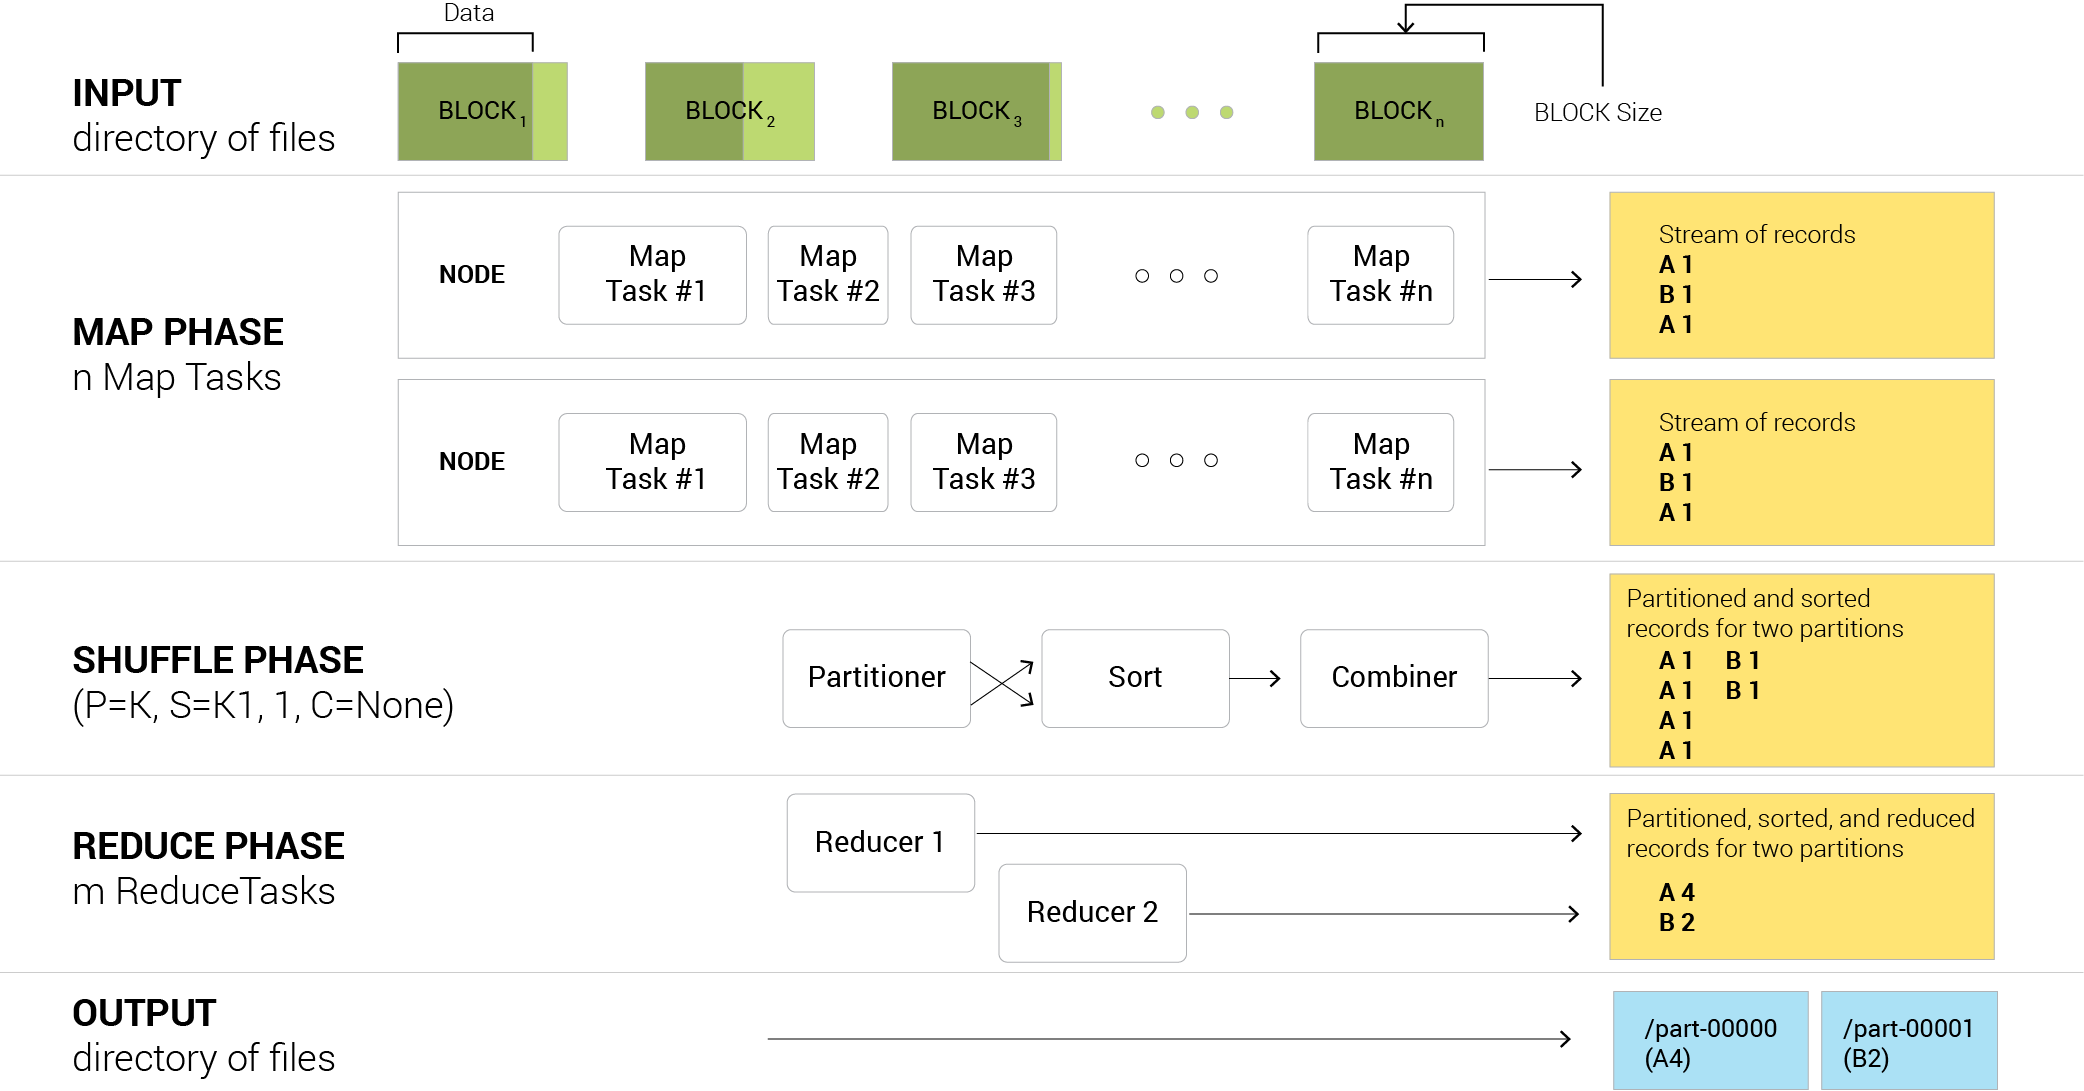

In [171]:
Image('anatomy-of-MR.png')

<em>Figure 1: Anatomy of a MapReduce Job from input data to output data via map, shuffle, and reduce steps.
</em>

<hr>
<h2><a name="Terminology">Terminology</a></h2>
<a href="#top">Back to top</a>


<a name="Hadoop"><strong>Apache Hadoop</strong></a> is a framework for running applications on large clusters built of commodity hardware. The Hadoop framework transparently provides applications both reliability and data motion. Hadoop implements a computational paradigm named Map/Reduce, where the application is divided into many small fragments of work, each of which may be executed or re-executed on any node in the cluster. In addition, it provides a distributed file system (HDFS) that stores data on the compute nodes, providing very high aggregate bandwidth across the cluster. Both MapReduce and the Hadoop Distributed File System are designed so that node failures are automatically handled by the Hadoop framework. 
http://wiki.apache.org/hadoop/

<a name="Partial-Sort"><strong>Partial Sort</strong></a> - The reducer output will be lot of (partition) files, each of which contains key-value records that are sorted within each partition file based on the key. This is the default behavior for MapReduce frameworks such as Hadoop.   

<a name="Total-Sort-(Unorderd-Partitions)"><strong>Total Sort (Unordered partitions)</strong></a> - Total sort refers to an ordering of all key-value pairs based upon a specified key. This total ordering will run across all output partition files unlike the partial sort described above. One caveat here is that partition files will need to be re-stacked to generate a total ordering (a small post-processing step that is required after the map-reduce job finishes).

<a name="Total-Sort-(Ordered-Partitions)"><strong>Total Sort (Ordered partitions)</strong></a> - Total sort where the partition file names are also assigned in order.

<a name="Secondary-Sorting"><strong>Secondary Sort</strong></a> - Secondary sorting refers to controlling the ordering of records based on the key and also using the values (or part of the value). That is, sorting can be done on two or more field values.


<h2><a name="HadoopStreaming">Hadoop Streaming</a></h2>
<a href="#top">Back to top</a>

<a name="Hadoop-Streaming"><strong>[Hadoop Streaming](http://hadoop.apache.org/docs/stable1/streaming.html#Hadoop+Streaming)</strong></a> is a utility that comes with the Hadoop distribution. The utility allows a user to create and run Map-Reduce jobs with any executable or script as the mapper and/or the reducer.



In [1]:
$HADOOP_HOME/bin/hadoop  jar $HADOOP_HOME/hadoop-streaming.jar \
    -input myInputDirs \
    -output myOutputDir \
    -mapper /bin/cat \
    -reducer /bin/wc

In the above example, both the mapper and the reducer are executables that read the input from stdin (line by line) and emit the output to stdout. The utility will create a MapReduce job, submit the job to an appropriate cluster, and monitor the progress of the job until it completes. When an executable is specified for mappers, each mapper task will launch the executable as a separate process when the mapper is initialized.    

As the mapper task runs, it converts its inputs into lines and feeds the lines to the stdin of the process. In the meantime, the mapper collects the line oriented outputs from the stdout of the process and converts each line into a key/value pair, which is collected as the output of the mapper. By default, the prefix of a line up to the first tab character is the key and the rest of the line (excluding the tab character) is the value. If there is no tab character in the line, then the entire line is considered the key and the value is null. However, this can be customized, as discussed later.   

When an executable is specified for reducers, each reducer task launches the executable as a separate process, and then the reducer is initialized. As the reducer task runs, it converts its input key/values pairs into lines and feeds the lines to the stdin of the process. In the meantime, the reducer collects the line-oriented outputs from the stdout of the process, converts each line into a key/value pair, which is collected as the output of the reducer. By default, the prefix of a line up to the first tab character is the key and the rest of the line (excluding the tab character) is the value. However, this can be customized, as discussed later.   

This is the basis for the communication protocol between the MapReduce framework and the streaming mapper/reducer.

<h2><a name="Examples">Examples of Different Sort Types (in context of Hadoop and HDFS)</a></h2>
<a href="#top">Back to top</a>


Demonstrated below is an example dataset in text format on HDFS. It includes three partitions in an HDFS directory. Each partition stores records in the format of `{Integer} [TAB] {English Word}`.

<pre>
files in hdfs directory
2016-07-20 22:04:56          0 _SUCCESS
2016-07-20 22:04:45    2392650 part-00000
2016-07-20 22:04:44    2368850 part-00001
2016-07-20 22:04:45    2304038 part-00002
</pre>
<hr />


<main>
  
  <input class="tab-state" id="tab4" type="radio" name="sortExamples" checked>
  <label for="tab4">Partial Sort</label>
    
  <input class="tab-state" id="tab5" type="radio" name="sortExamples">
  <label for="tab5">Total Sort (Unorderd Partitions)</label>
    
  <input class="tab-state" id="tab6" type="radio" name="sortExamples">
  <label for="tab6">Total Sort (Ordered Partitions)</label>
    
  <section id="content4" class="tab">

<h3>Partial Sort</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">27</span>   driver
<span style="color:red">27</span>   creating
<span style="color:red">27</span>   experiements
<span style="color:red">19</span>   consists
<span style="color:red">19</span>   evaluate
<span style="color:red">17</span>   drivers
<span style="color:red">10</span>   clustering
 <span style="color:red">9</span>   during
 <span style="color:red">9</span>   change
 <span style="color:red">7</span>   contour
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span>   do
<span style="color:red">28</span>   dataset
<span style="color:red">15</span>   computing
<span style="color:red">15</span>   document
<span style="color:red">15</span>   computational
<span style="color:red">14</span>   center
 <span style="color:red">5</span>   distributed
 <span style="color:red">4</span>   develop
 <span style="color:red">3</span>   different
 <span style="color:red">2</span>   cluster
</pre>
</td>
<td>
<pre>
<span style="color:red">26</span>   descent
<span style="color:red">26</span>   def
<span style="color:red">25</span>   compute
<span style="color:red">24</span>   done
<span style="color:red">24</span>   code
<span style="color:red">23</span>   descent
<span style="color:red">22</span>   corresponding
<span style="color:red">13</span>   efficient
 <span style="color:red">1</span>   cell
 <span style="color:red">0</span>   current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets without any ordering. Keys are sorted within each bucket (the key is the the number in the first column rendered in red).</caption>
</table>

</section>
<section id="content5" class="tab">


<h3>Total Sort (Unorderd Partitions)</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">19</span> 	consists
<span style="color:red">19</span> 	evaluate
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
</pre>
</td>
<td>
<pre>
<span style="color:red">10</span>  clustering
<span style="color:red">9</span>   during
<span style="color:red">9</span>   change
<span style="color:red">7</span>   contour
<span style="color:red">5</span>   distributed
<span style="color:red">4</span>   develop
<span style="color:red">3</span>   different
<span style="color:red">2</span>   cluster
<span style="color:red">1</span>   cell
<span style="color:red">0</span>   current
</pre>
</td>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	descent
<span style="color:red">26</span> 	def
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	done
<span style="color:red">24</span> 	code
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Partitions are not assigned in sorted order.</caption>
</table>

</section>
<section id="content6" class="tab">

<h3>Total Sort (Ordered Partitions)</h3>
<table>
<tr>
<td><pre>file: part-00000</pre></td>
<td><pre>file: part-00001</pre></td>
<td><pre>file: part-00002</pre></td>
</tr>
<tr>
<td>
<pre>
<span style="color:red">30</span> 	do
<span style="color:red">28</span> 	dataset
<span style="color:red">27</span> 	creating
<span style="color:red">27</span> 	driver
<span style="color:red">27</span> 	experiements
<span style="color:red">26</span> 	def
<span style="color:red">26</span> 	descent
<span style="color:red">25</span> 	compute
<span style="color:red">24</span> 	code
<span style="color:red">24</span> 	done
<span style="color:red">23</span> 	descent
<span style="color:red">22</span> 	corresponding
</pre>
</td>
<td>
<pre>
<span style="color:red">19</span> 	evaluate
<span style="color:red">19</span> 	consists
<span style="color:red">17</span> 	drivers
<span style="color:red">15</span> 	document
<span style="color:red">15</span> 	computing
<span style="color:red">15</span> 	computational
<span style="color:red">14</span> 	center
<span style="color:red">13</span> 	efficient
<span style="color:red">10</span> 	clustering
</pre>
</td>
<td>
<pre>
<span style="color:red">9</span> 	during
<span style="color:red">9</span> 	change
<span style="color:red">7</span> 	contour
<span style="color:red">5</span> 	distributed
<span style="color:red">4</span> 	develop
<span style="color:red">3</span> 	different
<span style="color:red">2</span> 	cluster
<span style="color:red">1</span> 	cell
<span style="color:red">0</span> 	current
</pre>
</td>
</tr>
<caption align='bottom'>Keys are assigned to buckets according to their numeric value. The result is that all keys between 20-30 end up in one bucket, keys between 10-20 end up in another bucket, and keys 0-10 end up in another bucket. Keys are sorted within each bucket. Here, partitions are assigned in sorted order, such that keys between 20-30 end up in the first bucket, keys between 10-20 end up in the second bucket, and keys 0-10 end up in the third bucket. We use the term buckets and partitions interchageably.</caption>
</table>
</section>
</main>

# Prepare Dataset
<a href="#top">Back to top</a>

Here we generate the data which we will use throughout the rest of this notebook. This is a toy dataset with 30 records, and consists of two fields in each record, separated by a tab character. The first field contains random integers between 1 and 30 (a hypothetical word count), and the second field contains English words. <strong>The goal is to sort the data by word count from highest to lowest.
</strong>

In [296]:
%%writefile generate_numbers.py
#!/usr/bin/python
words = ["cell","center","change","cluster","clustering","code","computational","compute","computing","consists",\
         "contour","corresponding","creating","current","dataset","def","descent","descent","develop","different",\
         "distributed","do","document","done","driver","drivers","during","efficient","evaluate","experiements"]
import random
N = 30
for n in range(N):
    print random.randint(0,N),"\t",words[n]

Overwriting generate_numbers.py


In [297]:
# give the python file exacutable permissions, write the file, and inspect number of lines
!chmod +x generate_numbers.py;
!./generate_numbers.py > generate_numbers.output
!wc -l generate_numbers.output

30 generate_numbers.output


In [298]:
# view the raw dataset
!cat generate_numbers.output

11 	cell
5 	center
14 	change
24 	cluster
12 	clustering
27 	code
19 	computational
18 	compute
21 	computing
20 	consists
29 	contour
10 	corresponding
0 	creating
12 	current
14 	dataset
9 	def
2 	descent
12 	descent
26 	develop
8 	different
6 	distributed
3 	do
23 	document
6 	done
21 	driver
23 	drivers
11 	during
3 	efficient
28 	evaluate
1 	experiements


<h1><a name="Section1">Section I - Understanding Unix Sort</a></h1>
<a href="#top">Back to top</a>

<h2><a name="importance-of-unix-sort">Importance of Unix Sort</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>   

Sort is a simple and very useful command found in Unix systems. It rearranges lines of text numerically and/or alphabetically. Hadoop Streaming's KeyBasedComparator is modeled after Unix sort, and utilizes command line options which are the same as Unix sort command line options.

<h3><a name="unix-sort-overview">Unix Sort Overview</a></h3>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>

```
# sort syntax
sort [OPTION]... [FILE]...
```

Sort treats a single line of text as a single datum to be sorted. It operates on fields (by default, the whole line is considered a field). It uses tabs as the delimiter by default (which can be configured with -t option), and splits a (non-empty) line into one or more parts, whereby each part is considered a field. Each field is identified by its index (POS).   

The most important configuration option is perhaps -k or --key.
Start a key at POS1 (origin 1), end it at POS2 (default end of line):

```
-k, --key=POS1[,POS2]
```

For example, -k1 (without ending POS), produces a key that is the whole line, and -k1,1 produces a key that is the first field. Multiple -k options can be supplied, and applied left to right. Sort keys can be tricky sometimes, and should be treated with care. For example:


```
sort –k1 –k2,2n
``` 

Will not work properly, as -k1 uses the whole line as key, and trumps -k2,2n.   

Another example:

```
sort -k2 -k3
```

This is redundant: it's equivalent to sort -k2.   

A good practice for supplying multiple sort keys is to make sure they are non-overlapping. 

Other commonly used flags/options are: -n, which sorts the keys numerically, and -r which reverses the sort order.



<h2><a name="sort-examples">  <span style="font-family:courier;font-weight:normal;">sort</span> examples </a></h2>
<a href="#top">Back to top</a>  | <a href="#Section1">Back to Section I</a>

(Source: http://www.theunixschool.com/2012/08/linux-sort-command-examples.html)

In [299]:
%%writefile unix-sort-example.txt
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25

Overwriting unix-sort-example.txt


<main>
  
  <input class="tab-state" id="tab7" type="radio" name="moreSortExamples" checked>
  <label for="tab7">sort -t"," -k1,1</label>
    
  <input class="tab-state" id="tab8" type="radio" name="moreSortExamples">
  <label for="tab8">sort -t"," -k2,2nr</label>
    
  <input class="tab-state" id="tab9" type="radio" name="moreSortExamples">
  <label for="tab9">sort -t"," -k1,1 -k2,2nr</label>
    
  <section id="content7" class="tab">


Sort by field 1 (default alphabetically), deliminator ","    


<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k1,1 unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
AIX,25
HPUX,100
Linux,20
Linux,25
Solaris,10
Unix,30
</pre></td>
</tr>
</table>

</section>
<section id="content8" class="tab">

Sort by field 2 numerically reverse, deliminator ","   

<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k2,2nr  unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
HPUX,100
Unix,30
AIX,25
Linux,25
Linux,20
Solaris,10
</pre></td>
</tr>
</table>

</section>
<section id="content9" class="tab">

Sort by field 1 alphabetically first, then by field 2 numeric reverse   

<table>
<tr>
<td><pre>cat unix-sort-example.txt</pre></td>
<td><pre>sort -t"," -k1,1 -k2,2nr  unix-sort-example.txt</pre></td>
</tr>
<tr>
<td><pre>
Unix,30
Solaris,10
Linux,25
Linux,20
HPUX,100
AIX,25
</pre></td>
<td><pre>
AIX,25
HPUX,100
Linux,25
Linux,20
Solaris,10
Unix,30
</pre></td>
</tr>
</table>

</section>
</main>

<h1><a name="Section2">Section II - Hadoop Streaming</a></h1>
<a href="#top">Back to top</a>   
<ul class="toc-item">
    <li><a href="#II.A.-Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></li>
    <li><a href="#Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></li>
    <ul>
      <li><a href="#Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></li>
      <li><a href="#Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></li>
      <li><a href="#Configure-Hadoop-Streaming-2"> Configure Hadoop Streaming: Step 2</a></li>
      <li><a href="#Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></li>
      <li><a href="#Summary-of-Common-Practices">Summary of Common Practices of Sorting Related Configuration</a></li>
      <li><a href="#Side-by-side-Examples">Side-by-side Examples: unix sort vs. hadoop streaming</a></li>
    </ul>
    </li>
    <li>
      <a href="#Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a>
      <ul>
        <li><a href="#single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></li>
        <li><a href="#multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a>
          <ul>
            <li><a href="#What's-new:-">What's New</a></li>
            <li><a href="#Multiple-Reducer-Overview">Multiple Reducer Overview</a></li>
            <li><a href="#Introductory-Example:">Introductory Example</a></li>
            <li><a href="#Implementation-Walkthrough">Implementation Walkthrough</a></li>
            
          </ul>
        </li>
      </ul>
    </li>
</ul>

<h2><a name="Hadoop's-Default-Sorting-Behavior">II.A. Hadoop's Default Sorting Behavior</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 
<h4>Key points:</h4> 
<ul>
<li>By default, Hadoop performs a partial sort on mapper output keys, i.e. within each partition keys are sorted.
</li>
<li>By default, keys are sorted as strings.
    <ul>
        <li>When processing a mapper output record, first the partitioner decides which partition the record should be sent to.</li>
        <li>In shuffle and sort stage, keys within a partition are sorted. </li>
        </ul>
</li>
<li>If there is only one partition, mapper output keys will be sorted in total order</li>
<li>The partition index of a given key from mapper outputs is determined by the partitioner, the  default partitioner is HashPartitioner which relies on Java’s hashCode function to compute an integer hash for the key. The partition index is derived next by hash modulo number of reducers.
</li>
</ul>

<h2><a name="Hadoop-streaming-parameters">II.B. Hadoop Streaming parameters</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Hadoop streaming can be further fine-grain controlled through the command line options below. Through these, we can fine-tune the Hadoop framework to better understand line-oriented record structure, and achieve the versatility of single-machine Unix sort, but in a distributed and efficient manner.


```
stream.num.map.output.key.fields
stream.map.output.field.separator
mapreduce.partition.keypartitioner.options
KeyFieldBasedComparator
keycomparator.options
partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
```
In a sorting task, Hadoop Streaming provides the same interface as Unix sort. Both consume a stream of lines of text, and produce a permutation of input records, based on one or more sort keys extracted from each line of input. Without customizing its sorting and partitioning, Hadoop Streaming treats implicitly each input line as a record consisting of a single key and value, separated by a "tab" character.   

Just like the various options Unix sort offers, Hadoop Streaming can be customized to use multiple fields for sorting, sort records by numeric order or keys and sort in reverse order.   

The following table provides an overview of relationships between Hadoop Streaming sorting and Unix sort:

<table width="100%">
<tr>
    <th></th>
    <th>Unix <span class="code">sort</span></th>
    <th>Hadoop streaming</th>
</tr>
<tr>
    <td>Key Field Separator</td>
    <td class="code">-t</td>
    <td class="code">-D stream.map.output.field.separator</td>
</tr>
<tr>
    <td>Number of Key Fields</td>
    <td>Not Required</td>
    <td class="code">-D stream.num.map.output.key.fields</td>
</tr>
<tr>
    <td>Key Range</td>
    <td class="code">-k, --key=POS1[,POS2]</td>
    <td><span class="code">-D mapreduce.partition.keycomparator.options</span>   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Numeric Sort</td>
    <td class="code">-n, --numeric-sort</td>
    <td><span class="code">-D mapreduce.partition.keycomparator.options</span>   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Reverse Order</td>
    <td class="code">-r --reverse</td>
    <td><span class="code">-D mapreduce.partition.keycomparator.options</span>   (same syntax as unix sort)</td>
</tr>
<tr>
    <td>Partitioner Class</td>
    <td>Not Applicable</td>
    <td class="code">-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner</td>
</tr>
<tr>
    <td>Comparator Class</td>
    <td>Not Applicable</td>
    <td class="code">-D mapreduce.job.output.key.comparator.class</td>
</tr>
<tr>
    <td>Partition Key Fields</td>
    <td>Not Applicable</td>
    <td class="code">-D mapreduce.partition.keypartitioner.options</td>
</tr>
</table>


Therefore, given a distributed sorting problem, it is always helpful to start with a non-scalable solution that can be provided by Unix sort and work out the required Hadoop Streaming configurations from there.


<h3><a name="Configure-Hadoop-Streaming-0"> Configure Hadoop Streaming: Prerequisites</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>    

```
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner        
```

These two options instruct Hadoop Streaming to use two specific Hadoop Java library classes: KeyFieldBasedComparator and KeyFieldBasedPartitioner. They come in standard Hadoop distribution, and provide the required machinery.


<h3><a name="Configure-Hadoop-Streaming-1"> Configure Hadoop Streaming: Step 1</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     

Specify number of key fields and key field separator

```
  -D stream.num.map.output.key.fields=4 \
  -D mapreduce.map.output.key.field.separator=.
```

In Unix sort when input lines use a non-tab delimiter, we need to supply the -t separator option. Similarly in Hadoop Streaming, we need to specify the character to use as key separators. Common options include: comma",", period ".", and space " ".   

One additional hint to Hadoop is the number of key fields, which is not required for Unix sort. This helps Hadoop Streaming to only parse the relevant parts of input lines, as in the end only keys are sorted (not values) – therefore, Hadoop can avoid performing expensive parsing and sorting on value parts of input line records.


<h3><a name="Configure-Hadoop-Streaming-2">Configure Hadoop Streaming: Step 2</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     

Specify sorting options

```
  -D mapreduce.partition.keycomparator.options=-k2,2nr 
```

This part is very straightforward. Whatever one would do with Unix sort (eg. -k1,1 -k3,4nr), just mirror it for Hadoop Streaming. However it is crucial to remember that Hadoop only uses KeyFieldBasedComparator to sort records within partitions. Therefore, this step only helps achieve partial sort.

<h3><a name="Configure-Hadoop-Streaming-3">Configure Hadoop Streaming: Step 3</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>     


Specify partition key field

```
  -D mapreduce.partition.keypartitioner.options=-k1,1
```

In this step, we need to specify which key field to use for partitioning. There's no equivalent in Unix sort. One critical detail to keep in mind is that, even though Hadoop Streaming uses Unix sort --key option's syntax for mapreduce.partition.keypartitioner.options., no sorting will actually be performed. It only uses expressions such as -k2,2nr for key extraction; the nr flags will be ignored.   

In later sections we will discuss in detail how to incorporate sorting into the partitioner by custom partition key construction.


<h2><a name="Summary-of-Common-Practices">Summary of Common Practices for Sorting Related Configuration</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a>    

<!-- HTML generated using hilite.me --><div style="background: #ffffff; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%">  
  -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
  -D stream.num.map.output.key.fields=<span style="color: #0000FF">4</span> \
  -D map.output.key.field.separator=. \
  -D mapreduce.partition.keypartitioner.options=<span style="color: #0000FF">-k1,2</span> \
  -D mapreduce.job.reduces=<span style="color: #0000FF">12</span> \
  -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
</pre></div>


At bare minimum, we typically need to specify:

1. Use KeyFieldBasedPartitioner
2. Use KeyFieldBasedComparator
3. Key field separator (can be omitted if TAB is used as separator)
4. Number of key fields
5. Key field separator again for mapper (under a different config option)
6. Partitioner options (Unix sort syntax)
7. Number of reducer jobs

See [hadoop streaming official documentation](https://hadoop.apache.org/docs/r2.7.2/hadoop-streaming/HadoopStreaming.html) for more information (hadoop version = 2.7.2).


<h3><a name="Side-by-side-Examples">Side-by-side Examples: Unix sort vs. Hadoop Streaming</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

<table width="100%">
<tbody>

<tr>
    <td width="20%">Unix sort</td>
    <td>Hadoop Streaming</td>
</tr>


<tr>
<td>
    <pre>sort -t"," -k1,1</pre>
</td>
<td>
<pre>
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="," \
-D mapreduce.partition.keypartitioner.options=-k1,1\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
</pre>
</td>
</tr>

<tr>
<td>
<pre>sort -k1,1 -k2,3nr</pre>
</td>
<td>
<pre>
-D mapreduce.job.output.key.comparator.class=\
  org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D stream.num.map.output.key.fields=3 \
-D mapreduce.partition.keypartitioner.options="-k1,1 -k2,3nr"\
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner\
-D mapreduce.job.reduces=1
</pre>
</td>
</tr>


</tbody>
</table>

Note: in both examples we use only a single reduce job, which makes hadoop's partial sort equivalent to a total sort.

<h2><a name="Hadoop-streaming-implementation">II.C. Hadoop Streaming implementation</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

You will need to install, configure, and start Hadoop. Brief instructions follow, but detailed instructions are beyond the scope of this notebook.


<h3><a name="StartHadoop">Start Hadoop</a></h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 


To run the examples in this notebook you must use the w261 class Docker container, either locally, or in AWS.
* AWS region: N. California region (us-west-1) 
* public AMI: w261-linux-hadoop

In [9]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming.jar"
HDFS_DIR = "/user/root/TOS"

In [10]:
from os import environ
PATH  = environ['PATH']

In [11]:
# should you need to regenerate the file and put it in hdfs a second time, make sure to delete the existing file first:
!hdfs dfs -mkdir {HDFS_DIR}

In [12]:
# put the file in hdfs:
!hdfs dfs -mkdir {HDFS_DIR}/sort
!hdfs dfs -mkdir {HDFS_DIR}/output
!hdfs dfs -put generate_numbers.output {HDFS_DIR}/sort

In [13]:
# make sure it's really there:
!hdfs dfs -ls {HDFS_DIR}/sort/generate_numbers.output

-rw-r--r--   1 root supergroup        366 2020-05-21 10:55 /user/root/TOS/sort/generate_numbers.output


<h2><a name="single-reducer-hadoop-streaming">II.C.1. Hadoop Streaming Implementation - single reducer</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

<h3>Key points:</h3> 
<ul>
    <li>Single reducer guarantees a single partition</li>
    <li>Partial sort becomes total sort</li>
    <li>No need for secondary sorting </li>
    <li>Single Reducer becomes scalibility bottleneck</li>
</ul>
<h3>Steps</h3>

In the mapper shuffle sort phase, the data is sorted by the primary key, and sent to a single reducer. By specifying `/bin/cat/` for the mapper and reducer, we are telling Hadoop Streaming to use the identity mapper and reducer which simply output the input (Key,Value) pairs.

<h4>Setup:</h4>
<pre>
-D stream.num.map.output.key.fields=2 
-D stream.map.output.field.separator="\t" 
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" 
</pre>
First we'll specify the number of keys, in our case, 2. The count and the word are primary and secondary keys, respectively. Next we'll tell Hadoop Streaming that our field separator is a tab character. Lastly we'll use the keycompartor options to specify which keys to use for sorting. Here, -n specifies that the sorting is numerical for the primary key, and -r specifies that the result should be reversed, followed by k2 which will sort the words alphabetically to break ties. Refer to the Unix sort section above.

<span style="color:red"><strong>IMPORTANT:</strong></span> Hadoop Streaming is particular about the order in which options are specified.  

(For more information, see the docs here: https://hadoop.apache.org/docs/r1.2.1/streaming.html#Hadoop+Comparator+Class)

In [305]:
!hdfs dfs -rm -r {HDFS_DIR}/sort/output
!hadoop jar {JAR_FILE} \
-D stream.num.map.output.key.fields=2 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k1,1nr -k2,2" \
-mapper /bin/cat \
-reducer /bin/cat \
-input {HDFS_DIR}/sort/generate_numbers.output \
-output {HDFS_DIR}/sort/output

Deleted /user/root/TOS/sort/output
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob4497762318533089622.jar tmpDir=null
20/05/21 03:51:06 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/21 03:51:06 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/21 03:51:07 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/21 03:51:07 INFO mapreduce.JobSubmitter: number of splits:2
20/05/21 03:51:07 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1589906177930_0023
20/05/21 03:51:07 INFO impl.YarnClientImpl: Submitted application application_1589906177930_0023
20/05/21 03:51:07 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1589906177930_0023/
20/05/21 03:51:07 INFO mapreduce.Job: Running job: job_1589906177930_0023
20/05/21 03:51:13 INFO mapreduce.Job: Job job_1589906177930_0023 running in uber mode : false
20/05/21 03:51:13 INFO map

In [306]:
# Check to see that we have indeed generated a single output file
!hdfs dfs -ls {HDFS_DIR}/sort/output

Found 2 items
-rw-r--r--   1 root supergroup          0 2020-05-21 03:51 /user/root/TOS/sort/output/_SUCCESS
-rw-r--r--   1 root supergroup        391 2020-05-21 03:51 /user/root/TOS/sort/output/part-00000


In [307]:
# Print the results
print("="*100)
print("Single Reducer Sorted Output - Hadoop Streaming")
print("="*100)
!hdfs dfs -cat {HDFS_DIR}/sort/output/part-00000

Single Reducer Sorted Output - Hadoop Streaming
30 	center	
30 	corresponding	
30 	driver	
29 	cell	
29 	drivers	
28 	contour	
28 	descent	
28 	develop	
26 	dataset	
24 	consists	
24 	evaluate	
23 	clustering	
23 	experiements	
20 	def	
19 	efficient	
17 	computing	
17 	document	
16 	done	
12 	during	
9 	computational	
8 	do	
4 	compute	
4 	descent	
3 	current	
2 	change	
2 	cluster	
1 	creating	
1 	distributed	
0 	code	
0 	different	


<h2><a name="multiple-reducer-hadoop-streaming">II.C.2. Hadoop Streaming Implementation - multiple reducers</a></h2>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 


<h3>Key points:</h3> 
<ul>
    <li>Need to guarantee that every key in a single reducer is to be "pre-sorted" against all other reducers</li>
    <li>Requires knowledge of the distribution of values to be sorted - more about this later in the sampling section</li>
    <li>Uses secondary sort to order keys within each partition</li>
</ul>


<h3><strong>What's new</strong>: </h3>  

Now the mapper needs to emit an additional key for each record by which to partition. We partition by this new 'primary' key and sort by secondary and tertiary keys to break ties. Here, the partition key is the primary key.   

The following diagram illustrates the steps required to perform total sort in a multi-reducer setting:


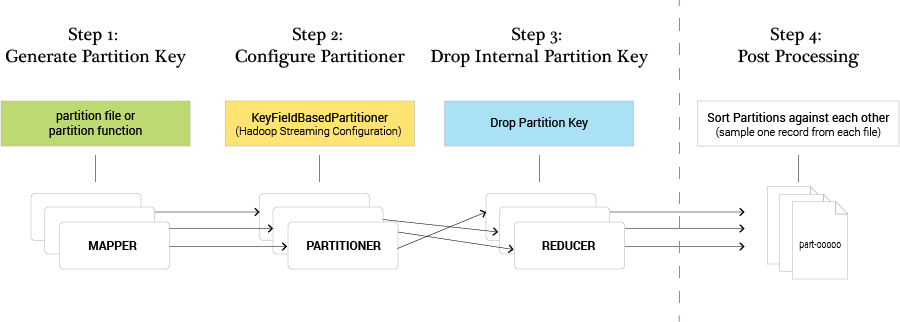

In [175]:
Image("TotalSortSteps2.png")

<em>Figure 2. Total Order sort with multiple reducers</em>

<h3>Multiple Reducer Overview</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 
   
<p></p>
After the Map phase and before the beginning of the Reduce phase there is a handoff process, known as shuffle and sort. Output from the mapper tasks is prepared and moved to the nodes where the reducer tasks will be run. To improve overall efficiency, records from mapper output are sent to the physical node that a reducer will be running on as they are being produced - to avoid flooding the network when all mapper tasks are complete.   

What this means is that when we have more than one reducer in a MapReduce job, Hadoop no longer sorts the keys globally (total sort). Instead mapper outputs are partitioned while they're being produced, and before the reduce phase starts, records are sorted by the key within each partition. In other words, Hadoop's architecture only guarantees partial sort.   

Therefore, to achieve total sort, a programmer needs to incorporate additional steps and supply the Hadoop framework additional aid during the shuffle and sort phase. Particularly, a partition file or partition function is required.

<h3>Version 1 - A two step approach</h3>

<h4>Step 1: Include a partition file or partition function inside mappers</h4>

Recall that we can use an identity mapper in single-reducer step up, which just echos back the (key, value) pair from input data. In a multi-reducer setup, we will need to add an additional "partition key" to instruct Hadoop how to partition records, and pass through the original (key, value) pair.   

The partition key is derived from the input key, with the help of either a partition file (more on this in the sampling section) or a user-specified partition function, which takes a key as input, and produces a partition key. Different input keys can result in same partition key.

Now we have two keys (as opposed to just one), and one is used for partitioning, the other is used for sorting. The reducer needs to drop the partition key which is used internally to aid total sort, and recover the original (key, value) pairs.

<h4>Step 2: Post-processing step to order partitions</h4>

The MapReduce job output is written to HDFS, with the output from each partition in a separate file (usually named something such as: part-00000). These file names are indexed and ordered. However, Hadoop makes no attempt to sort partition keys – the mapping between partition key and partition index is not order-preserving. Therefore, while partition keys key_1, key_2 and key_1 < key_2, it's possible that the output of partition with key_1 could be written to file part-00006 and the output of partition with key_2 written to file part-00003.   

Therefore, a post-processing step is required to finish total sort. Next, we'll provide an example of using linux to order the partition files. We will need to take one record from every (non-empty) partition output, sort them, and construct the appropriate ordering among partitions.


<h3>Introductory Example:</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Consider the task of sorting English words alphabetically, for example, four words from our example dataset:

<pre style="color: #BA2121">
experiements	
def	
descent	
compute	
</pre>

The expected sorted output is:
<pre style="color: #BA2121">
compute	
def	
descent	
experiements	
</pre>

We can use the first character from each word as a partition key. The input data could potentially have billions of words, but we will never have more than 26 unique partition keys (assuming all words are lower-cased). In addition, a word starting with "a" will always have a lower alphabetical ordering compared to a word which starts with "z". Therefore, all words belonging to partition "a" will be "pre-sorted" against all words from partition "z". The technique described here is equivalent to the following partition function:

<div style="background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">partition_function</span>(word):
    <span style="color: #008000; font-weight: bold">assert</span> <span style="color: #008000">len</span>(word) <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>
    <span style="color: #008000; font-weight: bold">return</span> word[<span style="color: #666666">0</span>]
</pre></div>

It is important to note that a partition function must preserve sort order, i.e. all partitions need to be sorted against each other. For instance, the following partition function is not valid (in sorting words in alphabetical order):

<div style="background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;"><pre style="margin: 0; line-height: 125%"><span style="color: #008000; font-weight: bold">def</span> <span style="color: #0000FF">partition_function</span>(word):
    <span style="color: #008000; font-weight: bold">assert</span> <span style="color: #008000">len</span>(word) <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>
    <span style="color: #008000; font-weight: bold">return</span> word[<span style="color: #666666">-1</span>]
</pre></div>



The mapper output or the four words with this partition scheme is:
<pre style="color: #BA2121">
e    experiements	
d    def	
d    descent	
c    compute	
</pre>

The following diagram outlines the flow of data with this example:

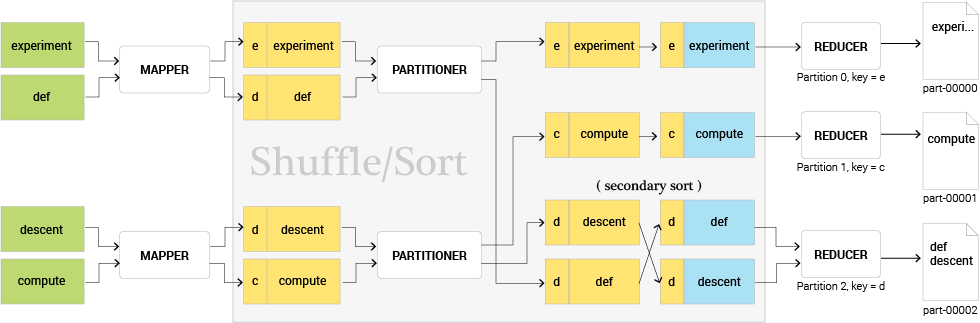

In [177]:
Image(filename="Partition2.png")

<em>Figure 3. Partial Order Sort</em>

Note that partition key "e" maps to partition 0, even if it is "greater than" key "d" and "c". This illustrates that the mapping between partition key and partition indices are not order preserving. In addition, sorting within partitions is based on the original key (word itself).


<h3>Implementation Walkthrough</h3>
<a href="#top">Back to top</a> | <a href="#Section2">Back to Section II</a> 

Coming back to our original dataset, here we will sort and print the output in two steps. Step one will partition and sort the data, and step two will arrange the partitions in the appropriate order. In the implementation that follows, we'll build on this and demonstrate how to ensure that the partitions are created in the appropriate order to begin with.

<ol>
    <li>Run the Hadoop command that prepends an alphabetic key to each row such that they end up in the appropriate partition, then shuffle and sort. </li>
    <li>Combine the secondary sort output files in the appropriate order</li>
</ol>

<h4>Setup</h4>

The following options comprise the Hadoop Streaming configuration for the sort job. Notice the addition of the keypartitioner option, which tells Hadoop Streaming to partition by the primary key. Remember that the order of the options is important.

```
-D stream.num.map.output.key.fields=3 \
-D stream.map.output.field.separator="\t" \
-D mapreduce.partition.keypartitioner.options=-k1,1 \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
```

Here, "-k1,1 -k2,2nr -k3,3" performs secondary sorting. Our three key fields are:

* `-k1,1`: partition key, one of $\{A, B, C\}$ (this part is optional, since each partition will contain the same partition key)
* `-k2,2nr`: input key (number/count), and we specify `nr` flags to sort them numerically reverse 
* `-k3,3`  : input value (word), if two records have same count, we break the tie by comparing the words alphabetically

### Function to prepend an alphabetic key to each row such that they end up in the appropriate partition

The following mapper is an identity mapper with a partition function included, it prepends an alphabetic key as partition key to input records. The letters A, B, and C are arbitrary, and as we'll see, do not correspond to any ordering of partition files.

In [310]:
%%writefile prependPartitionKeyMapper.py
#!/usr/bin/env python
import sys
for line in sys.stdin:
    line = line.strip()
    key, value = line.split("\t")
    if int(key) < 10:
        print "%s\t%s\t%s" % ("A", key, value)   
    elif int(key) < 20:
        print "%s\t%s\t%s" % ("B", key, value)   
    else:
        print "%s\t%s\t%s" % ("C", key, value)    

Overwriting prependPartitionKeyMapper.py


### __Step 1 - run the hadoop command specifying 3 reducers, the partition key, and the sort keys__

In [18]:
!hdfs dfs -rm -r {HDFS_DIR}/sort/secondary_sort_output
!hadoop jar {JAR_FILE} \
    -D stream.num.map.output.key.fields=3 \
    -D stream.map.output.field.separator="\t" \
    -D mapreduce.partition.keypartitioner.options=-k1,1 \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options="-k1,1 -k2,2nr -k3,3" \
    -mapper prependPartitionKeyMapper.py \
    -reducer /bin/cat \
    -file prependPartitionKeyMapper.py \
    -input {HDFS_DIR}/sort/generate_numbers.output \
    -output {HDFS_DIR}/sort/secondary_sort_output \
    -numReduceTasks 3 \
    -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner 

rm: `/user/root/TOS/sort/secondary_sort_output': No such file or directory
20/05/19 17:35:01 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [prependPartitionKeyMapper.py] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob5288394612382812866.jar tmpDir=null
20/05/19 17:35:02 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/19 17:35:02 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/19 17:35:03 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/19 17:35:03 INFO mapreduce.JobSubmitter: number of splits:2
20/05/19 17:35:03 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1589906177930_0003
20/05/19 17:35:03 INFO impl.YarnClientImpl: Submitted application application_1589906177930_0003
20/05/19 17:35:03 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1589906177930_0003/
20/05/19 17:

<h3> Check the output </h3>

In [19]:
!hdfs dfs -ls {HDFS_DIR}/sort/secondary_sort_output
print ("="*100)
print ("/part-00000")
print ("="*100)
!hdfs dfs -cat {HDFS_DIR}/sort/secondary_sort_output/part-00000
print ("="*100)
print( "/part-00001")
print ("="*100)
!hdfs dfs -cat {HDFS_DIR}/sort/secondary_sort_output/part-00001
print ("="*100)
print ("/part-00002")
print ("="*100)
!hdfs dfs -cat {HDFS_DIR}/sort/secondary_sort_output/part-00002

Found 4 items
-rw-r--r--   1 root supergroup          0 2020-05-19 17:35 /user/root/TOS/sort/secondary_sort_output/_SUCCESS
-rw-r--r--   1 root supergroup         76 2020-05-19 17:35 /user/root/TOS/sort/secondary_sort_output/part-00000
-rw-r--r--   1 root supergroup        217 2020-05-19 17:35 /user/root/TOS/sort/secondary_sort_output/part-00001
-rw-r--r--   1 root supergroup        158 2020-05-19 17:35 /user/root/TOS/sort/secondary_sort_output/part-00002
/part-00000
B	19 	efficient	
B	17 	computing	
B	17 	document	
B	16 	done	
B	12 	during	
/part-00001
C	30 	center	
C	30 	corresponding	
C	30 	driver	
C	29 	cell	
C	29 	drivers	
C	28 	contour	
C	28 	descent	
C	28 	develop	
C	26 	dataset	
C	24 	consists	
C	24 	evaluate	
C	23 	clustering	
C	23 	experiements	
C	20 	def	
/part-00002
A	9 	computational	
A	8 	do	
A	4 	compute	
A	4 	descent	
A	3 	current	
A	2 	change	
A	2 	cluster	
A	1 	creating	
A	1 	distributed	
A	0 	code	
A	0 	different	


### Step 2 - Combine the sorted output files in the appropriate order
The following code block peaks at the first line of each partition file to determine the order of partitions, and prints the contents of each partition in order, from largest to smallest. Notice that, while the files are arranged in total order, the partition file names are not ordered. We’ll tackle this issue in the next section.


In [ ]:
# The subprocess module allows you to spawn new (system) processes, connect to their input/output/error pipes, 
# and obtain their return codes. Ref: https://docs.python.org/2/library/subprocess.html
import subprocess 
import re

'''
subprocess.Popen()
Opens a new subprocess and executes the unix command in the args array, passing the output to STDOUT.
This is the equivalent of typing: 
hdfs dfs -ls {HDFS_DIR}/sort/secondary_sort_output/part-*
in the unix shell prompt
Even though we cannot see this output it would look like this:
-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00000
-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00001
-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00002
'''

p = subprocess.Popen(["hdfs", "dfs", "-ls", "/user/root/TOS/sort/secondary_sort_output/part-*" ],  
                     stdout=subprocess.PIPE, stderr=subprocess.STDOUT)


'''
Save the output of the above command to the 'lines' string variable by reading each line and appending it to the 'lines' string.
The resulting lines string should look like this:

'-rw-r--r--   1 koza supergroup        141 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00000\n-rw-r--r--   1 koza supergroup        164 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00001\n-rw-r--r--   1 koza supergroup        118 2016-08-20 19:25 /user/root/TOS/sort/secondary_sort_output/part-00002\n'

'''
lines=""
for line in p.stdout.readlines():
    lines = lines + str(line)

    
'''
The following regular expresion extracts the paths from 'lines', and appends each path to the outputPARTFiles list.
The resulting outputPARTFiles list should look like this:

['/user/root/TOS/sort/secondary_sort_output/part-00000',
 '/user/root/TOS/sort/secondary_sort_output/part-00001',
 '/user/root/TOS/sort/secondary_sort_output/part-00002']

'''    
regex = re.compile('(\/user\/root\/TOS\/sort\/secondary_sort_output\/part-\d*)')
it = re.finditer(regex, lines)

outputPARTFiles=[]
for match in it:
    outputPARTFiles.append(match.group(0))

'''
Next is where we peek at the first line of each file and extract the key. The resulting partKeys list should look like this:
[19, 30, 9]

For each file f in outputPARTFiles
    int(...)                            <-- this will convert the key returned by the commands that follow to an integer
    ["hdfs", "dfs", "-cat", f]          <-- cat the file 
    stdout=subprocess.PIPE              <-- to STDOUT
    stdout.read()                       <-- read the STDOUT into memory
    decode()                            <-- convert from bytes to string (for python 3)
    splitlines()[0]                     <-- split that output into lines, and return the first line (at index 0)
    split('\t')[1]                      <-- split that first line by tab character, and return the item at index 1 - this is the 'key'
    strip()                             <-- remove trailing and leading spaces so output is clean

'''    
partKeys=[]
for f in outputPARTFiles:
    partKeys.append(int(subprocess.Popen(["hdfs", "dfs", "-cat", f], stdout=subprocess.PIPE).stdout.read().decode().splitlines()[0].split('\t')[1].strip()))

    
'''
create a dict d assoicating each key with its corresponding file path. The resulting d dict should look like this:

{ 9: '/user/root/TOS/sort/secondary_sort_output/part-00002',
 19: '/user/root/TOS/sort/secondary_sort_output/part-00000',
 30: '/user/root/TOS/sort/secondary_sort_output/part-00001'}
 
 ^^ we now know that the largest key lives in part-00001, and we will display that file content first

'''    
d={}
for i in range(len(outputPARTFiles)):
    print ("part is %d, key is %d, %s" %(i, partKeys[i], outputPARTFiles[i]))
    d[partKeys[i]] = outputPARTFiles[i]

'''
Print the contents of each file in total sorted order, by sorting the d dict by key in reverse:

    sorted(d.items(), key=lambda x: x[0], reverse=True)   <-- sorts d dict by key x[0], in reverse
    print "%d:%s"%(k[0], k[1])                            <-- print the key k[0] and the path k[1]
    
    use a subprocess to read the contents of each file listed in d (k[1]) (see explanation above for subprocess)
    and print each line omitting leading and trailing spaces
'''
  
#TOTAL Sort in decreasing order
for k in sorted(d.items(), key=lambda x: x[0], reverse=True):
    print ("="*100)
    print ("%d:%s"%(k[0], k[1]))
    print ("="*100)
    p = subprocess.Popen(["hdfs", "dfs", "-cat", k[1]],  stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    for line in p.stdout.readlines():
        print (line.decode().strip())

<h2><a name="Partitioning-in-Hadoop-streaming">II.C.3 Hadoop Streaming Implementation - multiple reducers with ordered partitions</a></h2>
<a href="#top">Back to top</a>

<h4>Keypoints:</h4>

<ul>
<li>Challenge: which partition contains the largest/smallest values seems arbitrary</li>
    <li>Hadoop streaming <span class="code">KeyFieldBasedPartitioner</span> does not sort partition keys, even though it seemingly accepts Unix <span class="code">sort</span> compatible configurations</li>
</ul>

<h4>Solution:</h4>

<ul>
<li>Understand the inner working of <span class="code">HashPartitioner</span> and <span class="code">KeyFieldBasedPartitioner</span></li>
<li>Relationship between <span class="code">KeyFieldBasedPartitioner</span> and <span class="code">HashPartitioner</span>:   
<br>* <span class="code">KeyFieldBasedPartitioner</span> applies <span class="code">HashPartitioner</span> on configured key field(s)</li>
<li>Create the inverse function of <span class="code">HashPartitioner</span> and assign partition keys accordingly</li>
</ul>

<h3><a name="Understanding-HashPartitioner"> Understanding HashPartitioner</a></h3>
<a href="#top">Back to top</a>   | <a href="#Section3">Back to Section 3</a>

By default, Hadoop uses a library class `HashPartitioner` to compute the partition index for keys produced by mappers. It has a method called `getPartition`, which takes `key.hashCode() & Integer.MAX_VALUE` and finds the modulus using the number of reduce tasks. For example, if there are 10 reduce tasks, `getPartition` will return values 0 through 9 for all keys.

<pre>
// HashPartitioner

partitionIndex = (key.hashCode() & Integer.MAX_VALUE) % numReducers
</pre>

In the land of native hadoop applications (written in Java or JVM languages), keys can be any object type that is hashable (i.e. implements hashable interface). For Hadoop Streaming, however, keys are always string values. Therefore the hashCode function for strings is used:


<div style="margin:20px 0;background: #f8f8f8; overflow:auto;width:auto;border:0;border-width:.0;padding:.0;">
<pre style="margin: 0; line-height: 125%">
public <span style="color: #008000">int</span> hashCode() {
    <span style="color: #008000">int</span> h <span style="color: #666666">=</span> <span style="color: #008000">hash</span>;
    <span style="color: #008000; font-weight: bold">if</span> (h <span style="color: #666666">==</span> <span style="color: #666666">0</span> <span style="color: #666666">&amp;&amp;</span> value<span style="color: #666666">.</span>length <span style="color: #666666">&gt;</span> <span style="color: #666666">0</span>) {
        char val[] <span style="color: #666666">=</span> value;
        <span style="color: #008000; font-weight: bold">for</span> (<span style="color: #008000">int</span> i <span style="color: #666666">=</span> <span style="color: #666666">0</span>; i <span style="color: #666666">&lt;</span> value<span style="color: #666666">.</span>length; i<span style="color: #666666">++</span>) {
            h <span style="color: #666666">=</span> <span style="color: #666666">31</span> <span style="color: #666666">*</span> h <span style="color: #666666">+</span> val[i];
        }
        <span style="color: #008000">hash</span> <span style="color: #666666">=</span> h;
    }
    <span style="color: #008000; font-weight: bold">return</span> h;
}
</pre>
</div>


When we configure Hadoop Streaming to use KeyBasedPartitioner, the process is very similar. Hadoop Streaming will parse command line options such as -k2,2 into key specs, and extract the part of the composite key (in this example, field 2 of many fields) and read in the partition key as a string. For example, with the following configuration:

<pre>
"stream.map.output.field.separator" : ".",
"mapreduce.partition.keycomparator.options": "-k2,2",
</pre>

Hadoop will extract '<strong>a</strong>' from a composite key <strong>2.a.4</strong> to use as the partition key.

The partition key is then hashed (as string) by the same `hashCode` function, its modulus using number of reduce tasks yields the partition index.

See `KeyBasedPartitioner` [source code](https://github.com/apache/hadoop/blob/2e1d0ff4e901b8313c8d71869735b94ed8bc40a0/hadoop-mapreduce-project/hadoop-mapreduce-client/hadoop-mapreduce-client-core/src/main/java/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.java) for the actual implementations.

<h3><a name="Inverse-HashCode-Function">Inverse HashCode Function</a></h3>
<a href="#top">Back to top</a>   | <a href="#Section3">Back to Section 3</a>


In order to preserve partition key ordering, we will construct an "inverse hashCode function", which takes as input the desired partition index and total number of partitions, and returns the partition key. This key, when supplied to the Hadoop framework (KeyBasedPartitioner), will hash to the returned desired index.   

First, let's implement the core of HashPartitioner in Python:


In [20]:
def makeIndex(key, num_reducers):
    byteof = lambda char: int(format(ord(char), 'b'), 2)
    current_hash = 0
    for c in key:
        current_hash = (current_hash * 31 + byteof(c))
    return current_hash % num_reducers

# partition indexes for keys: A,B,C; with 3 partitions
[makeIndex(x, 3) for x in "ABC"]

[2, 0, 1]

A simple strategy to implement an inverse hashCode function is to use a lookup table. For example, assuming we have 3 reducers, we can compute the partition index with makeIndex for keys "A", "B", and "C". The results are listed the the table below.

| <strong>Partition Key</strong> | <strong>Partition Index</strong> |
|-------------------|---------------------|
| A                 | 2                   |
| B                 | 0                   |
| C                 | 1                   |


In the mapper stage, if we want to assign a record to partition 0, for example, we can simply look at the partition key that generated the partition index 0, which in this case is "B".


<h2><a name="illustration">Total Order Sort with ordered partitions - illustrated</a></h2>

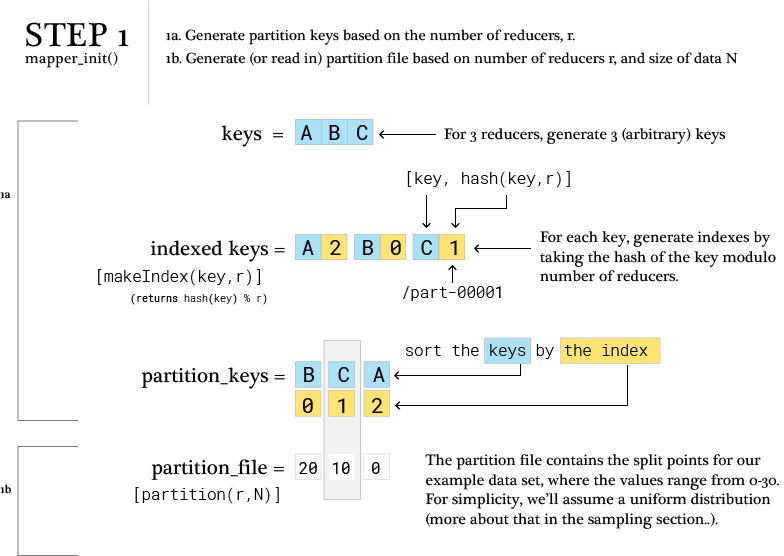

In [8]:
Image(filename="tos-step1.png")

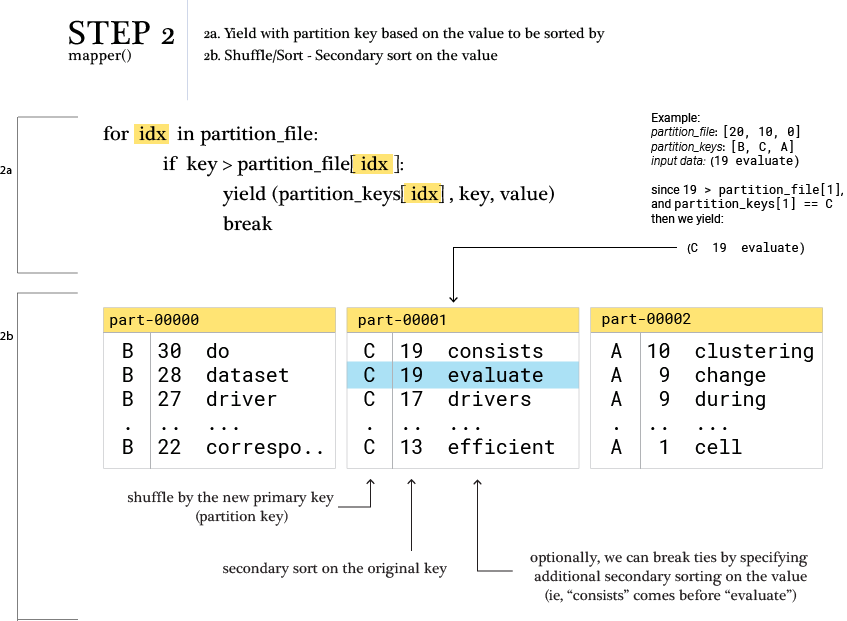

In [6]:
Image(filename="tos-step2.png")

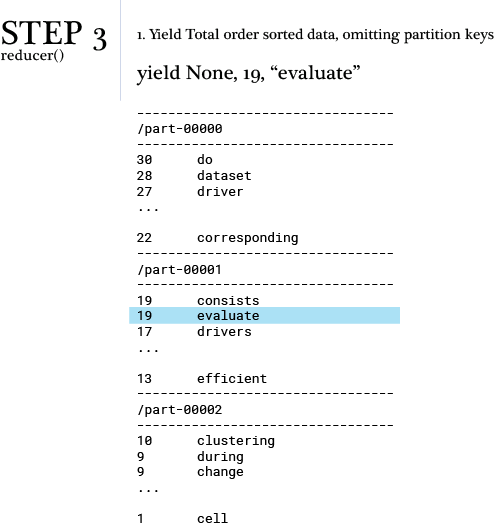

In [111]:
Image(filename="tos-step3.png")

<h2><a name="implementation">Implementation</a></h2>
<a href="#top">Back to top</a>  | <a href="#Section3">Back to Section 3</a>  

<h3>Version 2 - The final Total Order Sort with ordered partitions</h3>

<h4>What's New</h4>

The solution we will delve into is very similar to the one discussed earlier in the  [Hadoop Streaming](#multiple-reducer-hadoop-streaming)  section. The only addition is Step 1B, where we take a desired partition index and craft a custom partition key such that Hadoop's KeyFieldBasedPartitioner hashes it back to the correct index.


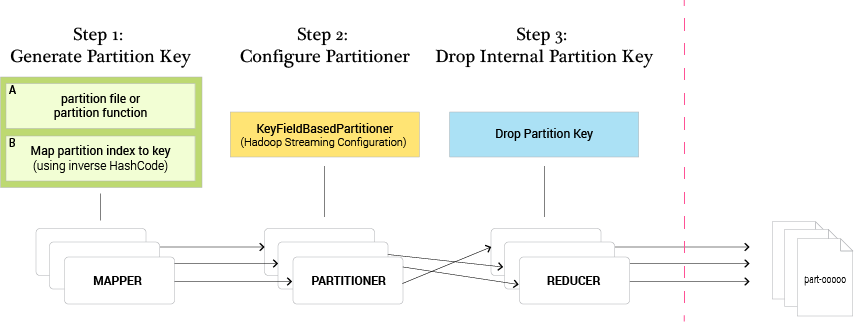

In [179]:
Image("TotalSortStepsComplete.png")

<em>Figure 6. Total order sort with custom partitioning.</em>

In [21]:
%%writefile multipleReducerTotalOrderSort_mapper.py
#!/usr/bin/env python
"""
INPUT:                                                    
    count \t word                
OUTPUT:                                                   
    partitionKey \t count \t word
"""

import os
import re                                                   
import sys                                                  
import numpy as np      
from operator import itemgetter

   
N = int(os.getenv('mapreduce_job_reduces', default=1))

def makeIndex(key, num_reducers = N):
    """
    Mimic the Hadoop string-hash function.
    
    key             the key that will be used for partitioning
    num_reducers    the number of reducers that will be configured
    """
    byteof = lambda char: int(format(ord(char), 'b'), 2)
    current_hash = 0
    for c in key:
        current_hash = (current_hash * 31 + byteof(c))
    return current_hash % num_reducers

def makeKeyFile(num_reducers = N):
    KEYS = list(map(chr, range(ord('A'), ord('Z')+1)))[:num_reducers]
    partition_keys = sorted(KEYS, key=lambda k: makeIndex(k,num_reducers))

    return partition_keys


# call your helper function to get partition keys
pKeys = makeKeyFile()

def makePartitionFile():
    # returns a list of split points
    # For the sake of simplicity this is hardcoded.
    # See the sampling section below for more information.
    return [20,10,0]

pFile = makePartitionFile()

for line in sys.stdin: 
    line = line.strip()
    key,value = line.split('\t')

    for idx in range(N):
        if float(key) > pFile[idx]:
            print(str(pKeys[idx])+"\t"+key+"\t"+value)
            break

Overwriting multipleReducerTotalOrderSort_mapper.py


In [22]:
%%writefile multipleReducerTotalOrderSort_reducer.py
#!/usr/bin/env python
"""
INPUT:
    partitionKey \t count \t word
OUTPUT:
    count \t word
"""
import sys

for line in sys.stdin:
    pkey, key, value = line.strip().split('\t')
    print(key,value)

Overwriting multipleReducerTotalOrderSort_reducer.py


In [23]:
!hdfs dfs -rm -r {HDFS_DIR}/sort/total_order_sort
!hadoop jar {JAR_FILE} \
    -D stream.num.map.output.key.fields=3 \
    -D stream.map.output.field.separator="\t" \
    -D mapreduce.partition.keypartitioner.options=-k1,1 \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options="-k2,2nr -k3,3" \
    -files multipleReducerTotalOrderSort_mapper.py,multipleReducerTotalOrderSort_reducer.py \
    -mapper multipleReducerTotalOrderSort_mapper.py \
    -reducer multipleReducerTotalOrderSort_reducer.py \
    -input {HDFS_DIR}/sort/generate_numbers.output \
    -output {HDFS_DIR}/sort/total_order_sort \
    -numReduceTasks 3 \
    -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
    -cmdenv PATH={PATH}

rm: `/user/root/TOS/sort/total_order_sort': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob3403073017835678931.jar tmpDir=null
20/05/19 18:19:46 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/19 18:19:47 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/19 18:19:47 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/19 18:19:47 INFO mapreduce.JobSubmitter: number of splits:2
20/05/19 18:19:47 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1589906177930_0005
20/05/19 18:19:47 INFO impl.YarnClientImpl: Submitted application application_1589906177930_0005
20/05/19 18:19:47 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1589906177930_0005/
20/05/19 18:19:47 INFO mapreduce.Job: Running job: job_1589906177930_0005
20/05/19 18:19:53 INFO mapreduce.Job: Job job_1589906177930_0005 running in uber mode

In [24]:
print ("="*100)
print ("Total Order Sort with multiple reducers - notice that the part files are also in order.")
print ("="*100)
print ("/part-00000")
print ("-"*100)
!hdfs dfs -cat {HDFS_DIR}/sort/total_order_sort/part-00000
print ("-"*100)
print ("/part-00001")
print ("-"*100)
!hdfs dfs -cat {HDFS_DIR}/sort/total_order_sort/part-00001
print ("-"*100)
print ("/part-00002")
print ("-"*100)
!hdfs dfs -cat {HDFS_DIR}/sort/total_order_sort/part-00002


Total Order Sort with multiple reducers - notice that the part files are also in order.
/part-00000
----------------------------------------------------------------------------------------------------
30  center	
30  corresponding	
30  driver	
29  cell	
29  drivers	
28  contour	
28  descent	
28  develop	
26  dataset	
24  consists	
24  evaluate	
23  clustering	
23  experiements	
----------------------------------------------------------------------------------------------------
/part-00001
----------------------------------------------------------------------------------------------------
20  def	
19  efficient	
17  computing	
17  document	
16  done	
12  during	
----------------------------------------------------------------------------------------------------
/part-00002
----------------------------------------------------------------------------------------------------
9  computational	
8  do	
4  compute	
4  descent	
3  current	
2  change	
2  cluster	
1  creating	
1  distributed	


<a name="illustration"></a>

<h3>Total Order Sort results</h3>
We now have exactly what we were looking for. Total Order Sort, with the added benefit of ordered partitions. Notice that the top results are stored in part-00000, the next set of results is stored in part-00001, etc..

<h1><a name="Section4">Section III - Sampling Key Spaces</a></h1>
<a href="#top">Back to top</a>   

Previously, we used a partition file which assumed our key space was uniformly distributed. In reality this is rarely the case, and we should make our partition file based on the actual distribution of the data to avoid bottlenecks. A bottleneck would occur if the majority of our data resided in a single bucket, as could happen with a typical power law distribution.

Consider the following example:

In [15]:
import random
import numpy as np

# Create a skewed distribution
# make 750,000 numbers between 0-10
# make 200,000 numbers between 10-20
# make 50,000 numbers between 20-30

A = np.random.uniform(0,10,750000)
B = np.random.uniform(10,20,200000)
C = np.random.uniform(20,30,50000)

ALL = np.hstack((A,B,C))
print(ALL.shape)

(1000000,)


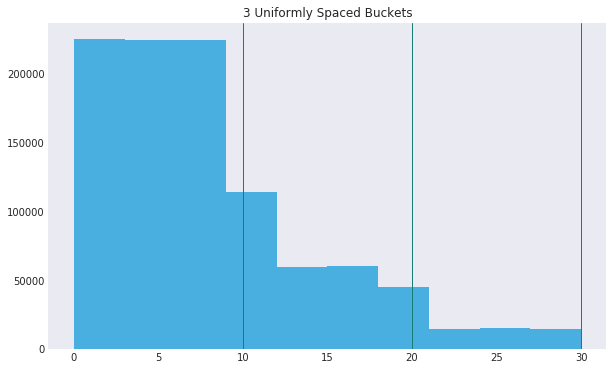

In [119]:
# Visualizae data distribution
%matplotlib inline
import pylab as pl
fig, ax = pl.subplots(figsize=(10,6))

ax.hist(ALL,color="#48afe0",edgecolor='none')

xcoords = [10,20,30]
for xc in xcoords:
    pl.axvline(x=xc,color="#197f74", linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


pl.title("3 Uniformly Spaced Buckets")
pl.show()

<em>Figure 7. Uniform partitions over skewed data.</em>

If we made a uniform partition file the (above example has 3 buckets), we would end up with most of the data in a single reducer, and this would create a bottle neck. To fix this, we must create a partition file that distributes the keys more evenly.


The challenge is that when our dataset set is large, creating the partition file can be costly. But as long as we know the shape of the distribution, we don't need the whole dataset to create resonable partitions. Next we'll look at two ways to take a random sample of a large datset. 

<h4>Key points:</h4>
<ol>
<li><a name="randomsampling"><b>Simple Random Sampling</b></a> - Easy implementation when we know the total size of the data</li>
<li><a name="reservoirsampling"><b>Reservoir Sampling</b></a> - A method to sample the data with equal probablity for all data points when the size of the data is unknown. The algorithm works as follows:
    <pre>
    n = desired sample size
    reservoir = []
    for d in data
        if reservoir size < n
            add d to reservoir
        else:
            choose random location in reservoir
            flip coin whether to replace the exisiting d with new d
    </pre>
    
    
</li>
</ol>
(This paper has a nice explanation of reservoir sampling, see: 2.2 Density-Biased Reservoir Sampling http://science.sut.ac.th/mathematics/pairote/uploadfiles/weightedkm-temp2_EB.pdf.)   

<h2><a name="III.A">III.A. Random Sample implementation</a></h2>
<a href="#top">Back to top</a>


In [17]:
# write numpy aray to file
np.savetxt('randomNumbers.out', ALL, fmt='%.18f')

In [18]:
# put file in HDFS
!hdfs dfs -rm -r {HDFS_DIR}/sort/random_numbers
!hdfs dfs -put randomNumbers.out {HDFS_DIR}/sort/random_numbers

rm: `/user/root/TOS/sort/random_numbers': No such file or directory


In [19]:
%%writefile RandomSample.py
#!/usr/bin/env python

import sys
import numpy as np

#########################################################
#  Emit a random sample of 1/100th of the data
#########################################################

for line in sys.stdin:
    s = np.random.uniform(0,1)
    if s < .01: 
        print(line.strip())

Overwriting RandomSample.py


In [20]:
!hdfs dfs -rm -r {HDFS_DIR}/sort/sampleData
!hadoop jar {JAR_FILE} \
    -files RandomSample.py \
    -mapper RandomSample.py \
    -input {HDFS_DIR}/sort/random_numbers \
    -output {HDFS_DIR}/sort/sampleData \
    -numReduceTasks 0 \
    -cmdenv PATH={PATH}

rm: `/user/root/TOS/sort/sampleData': No such file or directory
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob2041614838548135011.jar tmpDir=null
20/05/21 10:56:47 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/21 10:56:47 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/21 10:56:48 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/21 10:56:48 INFO mapreduce.JobSubmitter: number of splits:2
20/05/21 10:56:49 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590009070447_0002
20/05/21 10:56:50 INFO impl.YarnClientImpl: Submitted application application_1590009070447_0002
20/05/21 10:56:50 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590009070447_0002/
20/05/21 10:56:50 INFO mapreduce.Job: Running job: job_1590009070447_0002
20/05/21 10:57:02 INFO mapreduce.Job: Job job_1590009070447_0002 running in uber mode : fal

In [21]:
!hdfs dfs -ls {HDFS_DIR}/sort/sampleData/

Found 3 items
-rw-r--r--   1 root supergroup          0 2020-05-21 10:57 /user/root/TOS/sort/sampleData/_SUCCESS
-rw-r--r--   1 root supergroup     111430 2020-05-21 10:57 /user/root/TOS/sort/sampleData/part-00000
-rw-r--r--   1 root supergroup     111896 2020-05-21 10:57 /user/root/TOS/sort/sampleData/part-00001


In [22]:
!hdfs dfs -cat {HDFS_DIR}/sort/sampleData/part-* > sampleData.txt

In [23]:
!cat sampleData.txt | head

6.219041831485558447	
6.686344258768484039	
6.769544208921161932	
7.639744831367128342	
2.139872044496024195	
3.798373714588547667	
2.678375024342094513	
6.667164453774735655	
0.708364758734653099	
1.880770912957316909	
cat: write error: Broken pipe


In [24]:
!cat sampleData.txt | tail

28.039338755785088608	
25.345290806645600412	
26.379113474443627751	
29.636694380239692492	
26.722319640328059620	
29.877321118626916530	
28.115086968783938204	
24.174899488857747087	
21.898206840176925425	
26.753814102971556821	


<h2><a name="III.B">III.A. Reservoir Sample implementation</a></h2>
<a href="#top">Back to top</a>

### Review of Reservoir Sampling


Reservoir sampling ensures that each datum in the stream will be sampled with the same equal probability, and this is property makes the process true random sampling.


Let $N$ be the unknown length of the stream, and suppose we desire a random sample of size $n < N$. Furthermore, let $R$ denote the set of element indices which are in the reservoir at the end of the sampling process. 

`Description`: To begin, the first $n$ elements, elements $1,2,3 ...$ up to element $n$ get put in the reservoir in the form of a list. Next, the algorithm iterates through each element $i$ that comes after the $n^{th}$ element and considers putting it in the reservoir. When the algorithm is considering whether to place an element $i$ with $i >n$ in the reservoir, the algorithm takes a random index $J_i$ between $1$ and $i$ inclusively, that is $J_i \sim Unif\{1,..., i\}$. If $J_i \leq n$ then the currrent $J_i^{th}$ element of reservoir list is swapped with element $i$. If $J_i > n$ the algorithm doesn't do any swapping and proceeds to consider element $i+1$.

`Claim`: Each element in the stream has chance $\frac{n}{N}$ of being sampled (this means $k \in R$ by the end), thus making the sample a truly random sample.

`Proof`: Consider the $k^{th}$ element of the stream.

> Case 1: Suppose that $k \in \{1,2,...,n\}$. So element $k$ is one of the first elements to fill the reservoir to begin with. For element $k$ to end up in the final sample, element $k$ must not be replaced by any incoming elements of the stream. Let's find the chance that by the end of the process, $k$ is in the sample, $\mathbb{P}(k \in R)$:

\begin{align*}
\mathbb{P}(k \in R) 
& = \cap_{i = n+1}^N \mathbb{P}(J_i \neq k) \\
& = \cap_{i = n+1}^N \frac{i-1}{i} \\
& = \frac{(n)(n+1)(n+2) \cdot \cdot \cdot (N-1)}{(n+1)(n+2) \cdot \cdot \cdot (N)} \\
& = \frac{n}{N}
\end{align*}

> Case 2: Suppose that $k > n$. So $k$ is not in the reservoir to begin with. When element $k$ is being considered for the reservoir, it must be swapped with some element that is currently in the reservoir in order to have $k$ end up in the final sample. After $k$ has replaced another element in the reservoir, element $k$ must not be replaced by any element that follows it.

\begin{align*}
\mathbb{P}(k \in R) 
& = \mathbb{P}(J_k \leq n) \cap_{i = k+1}^N \mathbb{P}(J_i \neq k) \\
& = \frac{n}{k} \cap_{i = k+1}^N \frac{i-1}{i} \\
& = \frac{n}{k} \cdot \frac{(k)(k+1)(k+2) \cdot \cdot \cdot (N-1)}{(k+1)(k+2) \cdot \cdot \cdot (N)} \\
& = \frac{n}{k} \cdot \frac{k}{N} \\
& = \frac{n}{N}
\end{align*}

The following code block creates a small data set for unit/systems testing:

In [140]:
%%writefile numberPopulationTest.txt
3
55
6
4
10
2
1
67
3
20
9
19
11
0
88

Overwriting numberPopulationTest.txt


### Naive Implementation
In its most basic form, a reservoir sampling algorithm keeps a list of datapoints (the reservoir) in memory. Unfrotunately, this version doesn't scale to multiple mappers, and thus is not fit for purpose. Here it is just for reference:

In [143]:
%%writefile ReservoirSample.py
#!/usr/bin/env python

import sys
import numpy as np

#########################################################
#  Sample n numbers uniformly at random
#########################################################

print(sys.argv)

R = 5 # size of the reservoir
res = [] # reservoir

for i, line in enumerate(sys.stdin):
    num = line.strip()
    if len(res) < R:
        res.append(num)
    else:
        j = np.random.randint(i)
        if j < R:
            res[j] = num

# print 
for j in res:
    print(j)

Overwriting ReservoirSample.py


In [145]:
# Systems test
!python ReservoirSample.py < numberPopulationTest.txt

['ReservoirSample.py']
11
20
6
2
10


### Parallel & Scalable Implementation Using Hadoop MapReduce

To implement reservoir sampling in a scalable way, we need to avoid holding the reservoir in memory. 
The core insight behind reservoir sampling is that picking a random sample of size R is equivalent to generating a random permutation (ordering) of the elements and picking the top R elements.

In the implementation below, leveraging secondary sort on random variate `i`, we can gaurantee that the top R elements are chosen by the reducers.


This can be done by first mapping over each data point `n` and emitting:
1. the data point itself, `n` 
2. the index `j` in the reservoir which `n` would occupy (if it were chosen to be swapped into the reservoir)
3. the index `i` of the data point in the stream 

Note that if `i` is less than the sample size, the data point should be automatically added to the reservoir at index `i`. So for these numbers, the mapper should emit `n`, `i`, `i`.

Next the reducers need to determine which data point will occupy the `j` location (for every location `j` in the reservoir) from among the data points that were assigned to swap into the `j` position in the reservoir. In the original algorithm, the data point that ultimately occupies the `j` position is the last data point in the stream that is assigned to swap into the `j` position. Therefore, in the reduce phase, the data point which gets printed for the `j` position should be, from among the data points with reservoir index `j`, the data point with the highest `i`, because this data point would have been the last element in the original stream.

In order for the reducers to be able to achieve this in a stateless manner, the intermediate key-value pairs should be partitioned by `j`, and then they should be sorted primarily by `j` and secondarily by `i` within each partition. 

An implementation of the required mapper and reducer for scalable and parallizable reservoir sampling is below:

In [146]:
%%writefile ReservoirSample_mapper.py
#!/usr/bin/env python
"""
INPUT:                                                    
    data point  
    R -> size of the reservoir
OUTPUT:                                                   
    data point \t reservoirIndex(j) \t streamIndex(i) 
"""
import os
import sys
import numpy as np


if os.getenv('R') == None:
    R = 3
else:
    R = int(os.getenv('R'))

for i, line in enumerate(sys.stdin):
    num = line.strip()
    
    if i < R:
        print(f'{num}\t{i}\t{i}')
    else:
        j = np.random.randint(i) 
        if j < R: 
            print(f'{num}\t{j}\t{i}')

Overwriting ReservoirSample_mapper.py


In [147]:
%%writefile ReservoirSample_reducer.py
#!/usr/bin/env python

"""
INPUT:                                                    
    data point \t reservoirIndex(j) \t streamIndex(i)             
OUTPUT:                                                   
    data point
    
Requirement: the inputs must be sorted with the 
following option: -k2,2 -k3,3n. This way all of 
records associated with position j in the reservoir
are consecutive and the one that will occupy position
j in the reservoir at the end is the one with the
highest stream index (the one that came last in
the original stream)
"""


import sys

current_j = None
current_num = None

for i, line in enumerate(sys.stdin):
    num, j, i = line.strip().split('\t')
    
    if current_j == j:
        current_num = num
    else:
        if current_j is not None:
            print(current_num)
        current_j = j
        current_num = num
        
print(current_num)

Overwriting ReservoirSample_reducer.py


In [148]:
!chmod +x ReservoirSample_mapper.py
!chmod +x ReservoirSample_reducer.py

In [180]:
!cat numberPopulationTest.txt | ./ReservoirSample_mapper.py | sort -k2,2n -k3,3n > mapper.out

In [181]:
!cat mapper.out

3	0	0
10	0	4
2	0	5
20	0	9
55	1	1
3	1	8
6	2	2
4	2	3


In [182]:
!cat mapper.out | ./ReservoirSample_reducer.py

20
3
4


In [183]:
!hdfs dfs -rm -r {HDFS_DIR}/sort/resSampleData
!hadoop jar {JAR_FILE} \
    -D stream.num.map.output.key.fields=3 \
    -D stream.map.output.field.separator="\t" \
    -D mapreduce.partition.keypartitioner.options=-k2,2n \
    -D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
    -D mapreduce.partition.keycomparator.options="-k2,2n -k3,3n" \
    -files ReservoirSample_mapper.py,ReservoirSample_reducer.py \
    -mapper ReservoirSample_mapper.py \
    -reducer ReservoirSample_reducer.py \
    -input {HDFS_DIR}/sort/random_numbers \
    -output {HDFS_DIR}/sort/resSampleData \
    -numReduceTasks 4 \
    -partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner \
    -cmdenv R=1000 \
    -cmdenv PATH={PATH}

Deleted /user/root/TOS/sort/resSampleData
packageJobJar: [] [/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.16.2.jar] /tmp/streamjob7123320903685861172.jar tmpDir=null
20/05/26 14:08:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/26 14:08:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
20/05/26 14:08:04 INFO mapred.FileInputFormat: Total input paths to process : 1
20/05/26 14:08:04 INFO mapreduce.JobSubmitter: number of splits:2
20/05/26 14:08:04 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1590009070447_0047
20/05/26 14:08:05 INFO impl.YarnClientImpl: Submitted application application_1590009070447_0047
20/05/26 14:08:05 INFO mapreduce.Job: The url to track the job: http://docker.w261:8088/proxy/application_1590009070447_0047/
20/05/26 14:08:05 INFO mapreduce.Job: Running job: job_1590009070447_0047
20/05/26 14:08:14 INFO mapreduce.Job: Job job_1590009070447_0047 running in uber mode : false
20/05/26 14:08:14 I

In [184]:
!hdfs dfs -ls {HDFS_DIR}/sort/resSampleData/

Found 5 items
-rw-r--r--   1 root supergroup          0 2020-05-26 14:08 /user/root/TOS/sort/resSampleData/_SUCCESS
-rw-r--r--   1 root supergroup       5599 2020-05-26 14:08 /user/root/TOS/sort/resSampleData/part-00000
-rw-r--r--   1 root supergroup       5610 2020-05-26 14:08 /user/root/TOS/sort/resSampleData/part-00001
-rw-r--r--   1 root supergroup       5572 2020-05-26 14:08 /user/root/TOS/sort/resSampleData/part-00002
-rw-r--r--   1 root supergroup       5575 2020-05-26 14:08 /user/root/TOS/sort/resSampleData/part-00003


In [185]:
!hdfs dfs -cat {HDFS_DIR}/sort/resSampleData/part-* > resSampleData.txt

In [186]:
!head -n 5 resSampleData.txt

5.574918167903911481	
1.571505454171698846	
0.752479853907217500	
11.253497108987883024	
13.504271654126098312	


In [187]:
!wc -l resSampleData.txt

1000 resSampleData.txt


<h2><a name="III.B">III.B. Custom partition file implementation</a></h2>
<a href="#top">Back to top</a>


<h3>Percentile Based Partitioning</h3>

Once we have a (small) sampled subset of data, we can compute partition boundaries by examining the distribution of this subset, and finding approporiate percentiles based on number of desired partitions. A basic implementation using NumPy is provided below:

In [188]:
def readSampleData(filePath):
    # A sample of the data is stored in a single file in sampleData/part-00000
    # from the previous step (RandomSample.py)
    sampleData = []  

    with open(filePath,"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip().split("\t")[0]
            sampleData.append(float(line))
            
    return sampleData

In [189]:
from numpy import array, percentile, linspace, random

def partition(data, num_of_partitions=3, return_percentiles=False):
    # remove percentile 100
    qs = linspace(0, 100, num=num_of_partitions, endpoint=False)
    if not return_percentiles:
        return percentile(data, qs)
    return percentile(data, qs), qs

In [190]:
sampleData = readSampleData('resSampleData.txt')
partitionFile, percentiles = partition(sampleData, 3, return_percentiles=True)

<h3> Visualize Partition </h3>

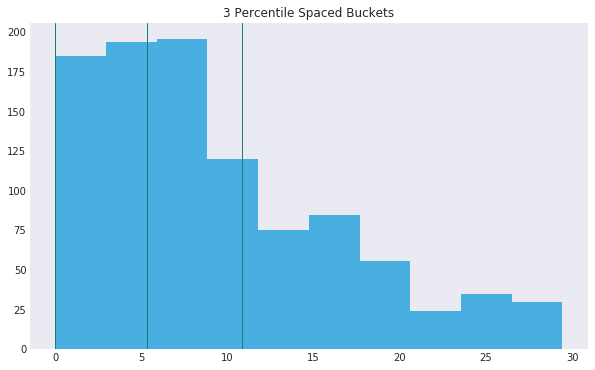

Sample Data min 0.001046762963181624
Sample Data max 29.43125395253612
Partition file [1.04676296e-03 5.30686396e+00 1.08147038e+01]
Percentiles [ 0.         33.33333333 66.66666667]


In [191]:
# Visualizae Partition File
%matplotlib inline
import pylab as pl

num_buckets = 3

fig, ax = pl.subplots(figsize=(10,6))

ax.hist(sampleData,color="#48afe0",edgecolor='none')

xcoords = partitionFile
for xc in xcoords:
    pl.axvline(x=xc,color="#197f74", linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


pl.title(str(num_buckets)+" Percentile Spaced Buckets")
pl.show()

print ("Sample Data min", min(sampleData))
print ("Sample Data max", max(sampleData))
print ("Partition file", partitionFile)
print ("Percentiles", percentiles)

<em>Figure 8. Percentile based partitions over skewed data.</em>

We could now replace the hard-coded partition file in our Total Order Sort implementation above with a custom file built from a sample of the data.

<h1> Final Remarks</h1>
<a href="#top">Back to top</a>   

A note on TotalSortPartitioner: Hadoop has built in TotalSortPartitioner, which uses a partition file _partition.lst to store a pre-built order list of split points.TotalSortPartitioner uses binary search / Trie to look up the ranges a given record falls into.

https://github.com/facebookarchive/hadoop-20/blob/master/src/mapred/org/apache/hadoop/mapred/lib/TotalOrderPartitioner.java

# References
<a href="#top">Back to top</a>   

<ol>

<li>http://wiki.apache.org/hadoop/</li>
<li>http://hadoop.apache.org/docs/stable1/streaming.html#Hadoop+Streaming</li>
<li>http://www.theunixschool.com/2012/08/linux-sort-command-examples.html</li>
<li>https://hadoop.apache.org/docs/r2.7.2/hadoop-streaming/HadoopStreaming.html</li>
<li>http://hadoop.apache.org/</li>
<li>https://hadoop.apache.org/docs/r2.7.2/hadoop-project-dist/hadoop-common/SingleCluster.html</li>
<li>https://hadoop.apache.org/docs/r1.2.1/streaming.html#Hadoop+Comparator+Class</li>
<li>http://docs.aws.amazon.com/ElasticMapReduce/latest/DeveloperGuide/emr-steps.html</li>
<li>https://github.com/apache/hadoop/blob/2e1d0ff4e901b8313c8d71869735b94ed8bc40a0/hadoop-mapreduce-project/hadoop-mapreduce-client/hadoop-mapreduce-client-core/src/main/java/org/apache/hadoop/mapreduce/lib/partition/KeyFieldBasedPartitioner.java</li>
<li>http://science.sut.ac.th/mathematics/pairote/uploadfiles/weightedkm-temp2_EB.pdf</li>
<li>http://spark.apache.org/</li>
<li>https://www2.eecs.berkeley.edu/Pubs/TechRpts/2011/EECS-2011-82.pdf</li>
<li>https://spark.apache.org/docs/1.6.2/programming-guide.html#working-with-key-value-pairs </li>
<li>https://github.com/facebookarchive/hadoop-20/blob/master/src/mapred/org/apache/hadoop/mapred/lib/TotalOrderPartitioner.java </li>
</ol>